### Importación de bibliotecas

In [87]:
import plotly.express as px
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import datetime
from sklearn.cluster import KMeans
from geopy.distance import geodesic 

In [3]:
# Load the dataset
file_path = 'rome_u_journeys.csv'  # Assuming the file is available in the working directory
# Load the CSV file into a DataFrame with specified column names
try:
    df = pd.read_csv(file_path, header=0)
    # Display the first few rows of the dataset to confirm loading
    df.head()
except FileNotFoundError:
    "The file 'rome_u_journeys.csv' was not found in the specified directory."

df

idS                  tsO                  tsD   price    tt  \
0      A0H4  03/02/2021 18:10:03  03/02/2021 18:17:44  2.1525   461   
1      A0H4  13/02/2021 18:21:13  13/02/2021 18:25:33  1.6500   260   
2      A0H4  14/02/2021 13:39:54  14/02/2021 13:48:03  2.2225   489   
3      A0H4  14/02/2021 14:35:03  14/02/2021 14:35:13  1.0250    10   
4      A0H4  14/02/2021 14:37:53  14/02/2021 14:57:53  4.0000  1200   
...     ...                  ...                  ...     ...   ...   
25181  Z9W9  25/02/2021 12:50:13  25/02/2021 12:57:14  2.0525   421   
25182  Z9W9  26/02/2021 13:34:13  26/02/2021 13:38:53  1.7000   280   
25183  Z9W9  26/02/2021 19:44:54  26/02/2021 19:52:33  2.1475   459   
25184  Z9W9  27/02/2021 17:01:24  27/02/2021 17:03:53  1.3725   149   
25185  Z9W9  28/02/2021 17:47:13  28/02/2021 18:00:23  2.9750   790   

               dis        vel       lonO       latO       lonD       latD  
0      1715.336751  13.395254  12.466222  41.867388  12.470660  41.853908  
1      1234.472044  17.092690  12.471143  41.923692  12.467502  41.934306  
2      2221.481536  16.354465  12.467524  41.934342  12.486330  41.928270  
3         3.712940   1.336658  12.486283  41.928267  12.486276  41.928300  
4      4562.843566  13.688531  12.486275  41.928301  12.457922  41.904302  
...            ...        ...        ...        ...        ...        ...  
25181  2385.131061  20.395420  12.501860  41.894429  12.481330  41.900720  
25182  1193.360009  15.343200  12.481623  41.900672  12.487869  41.893405  
25183   827.536316   6.490481  12.487891  41.893414  12.484797  41.894823  
25184   196.314727   4.743175  12.484793  41.894875  12.482676  41.895419  
25185  1746.609733   7.959234  12.482522  41.895278  12.482480  41.895280  

[25186 rows x 11 columns]

In [8]:
df.describe(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25186 entries, 0 to 25185
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   idS     25186 non-null  object 
 1   tsO     25186 non-null  object 
 2   tsD     25186 non-null  object 
 3   price   25186 non-null  float64
 4   tt      25186 non-null  int64  
 5   dis     25186 non-null  float64
 6   vel     25186 non-null  float64
 7   lonO    25186 non-null  float64
 8   latO    25186 non-null  float64
 9   lonD    25186 non-null  float64
 10  latD    25186 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 2.1+ MB


(              price             tt           dis           vel          lonO  \
 count  25186.000000   25186.000000  25186.000000  25186.000000  25186.000000   
 mean       3.034208     813.683237   1939.920890     11.486824     12.486697   
 std       11.970239    4788.095489   1656.689330      4.820036      0.022184   
 min        1.015000       6.000000      0.082808      0.001199     12.437227   
 25%        1.622500     249.000000    760.981361      8.454849     12.468673   
 50%        2.172500     469.000000   1506.437794     12.062827     12.483106   
 75%        3.125000     850.000000   2708.464547     15.126343     12.506559   
 max     1284.997500  513599.000000  18267.975980     61.026780     12.533779   
 
                latO          lonD          latD  
 count  25186.000000  25186.000000  25186.000000  
 mean      41.888974     12.486821     41.888953  
 std        0.023146      0.022395      0.023327  
 min       41.814922     12.435497     41.791932  
 25%       41.

In [4]:
import pandas as pd
import numpy as np

# Filtrar filas que contengan al menos un valor vacío, None, NaN, 0, o 0.0
rows_with_issues = df[
    df.isnull().any(axis=1) | (df == 0).any(axis=1)
]

# Obtener los índices (números de fila) de las filas con problemas
row_numbers = rows_with_issues.index.tolist()

print("Filas con valores vacíos, None, NaN, 0 o 0.0:", row_numbers)



Filas con valores vacíos, None, NaN, 0 o 0.0: []


### Mapas de calor

In [ ]:
# Convertir la columna `tsO` a formato datetime
df['tsO'] = pd.to_datetime(df['tsO'], format='%d/%m/%Y %H:%M:%S')

# Extraer la hora de `tsO` para agrupar los datos
df['hour'] = df['tsO'].dt.hour

# Crear un mapa base centrado en la ubicación media de los datos
mapa_base = folium.Map(location=[df['latO'].mean(), df['lonO'].mean()], zoom_start=12)

# Iterar sobre cada hora y agregar un HeatMap a la capa de horas
for hour in range(24):
    # Filtrar el DataFrame para la hora actual
    df_hour = df[df['hour'] == hour]
    
    # Crear una lista de puntos (latitud, longitud) para el HeatMap
    heat_data = list(zip(df_hour['latO'], df_hour['lonO']))
    
    # Agregar un mapa de calor para esta hora
    HeatMap(heat_data, radius=10, blur=15, max_zoom=1, name=f"Hora {hour}:00").add_to(mapa_base)

# Añadir una capa de control para activar/desactivar las capas de cada hora
folium.LayerControl().add_to(mapa_base)

# Guardar el mapa interactivo
mapa_base.save('mapa_calor_por_hora.html')

In [16]:
# Convertir la columna `tsO` a formato datetime
df['tsO'] = pd.to_datetime(df['tsO'], format='%d/%m/%Y %H:%M:%S')

# Extraer la hora de `tsO` para agrupar los datos
df['hour'] = df['tsO'].dt.hour

# Crear un diccionario para almacenar los datos de cada hora
hourly_data = []
for hour in range(24):
    # Filtrar los datos para cada hora
    df_hour = df[df['hour'] == hour]
    
    # Crear una lista de puntos (latitud, longitud, intensidad) para el HeatMap
    heat_data = [[row['latO'], row['lonO'], 1] for index, row in df_hour.iterrows()]
    
    # Añadir los datos de la hora actual al diccionario
    hourly_data.append(heat_data)

# Crear el mapa base centrado en la ubicación media de los datos
mapa_base = folium.Map(location=[df['latO'].mean(), df['lonO'].mean()], zoom_start=12)

# Crear el mapa de calor con el control de tiempo usando colores cálidos
HeatMapWithTime(
    hourly_data,
    radius=10,
    gradient={0.2: 'yellow', 0.5: 'orange', 0.7: 'red', 1: 'darkred'},  # Colores cálidos
    auto_play=False,
    max_opacity=0.8
).add_to(mapa_base)

# Guardar el mapa interactivo
mapa_base.save('mapa_calor_por_hora_interactivo.html')



### Clustering

In [110]:
# Combinar las coordenadas de origen y destino en un solo conjunto de datos
coords = pd.DataFrame({
    'lat': pd.concat([df['latO'], df['latD']], ignore_index=True),
    'lon': pd.concat([df['lonO'], df['lonD']], ignore_index=True)
})

# Configurar el número de clusters (estaciones de carga). Puedes ajustar n_clusters según tus necesidades
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=0)  # Se agrega n_init=10
coords['cluster'] = kmeans.fit_predict(coords[['lat', 'lon']])

# Obtener los centroides (posiciones ideales para las estaciones de carga)
centroids = kmeans.cluster_centers_

# Convertir los centroides en un DataFrame para visualización
centroids_df = pd.DataFrame(centroids, columns=['lat', 'lon'])

# Crear un mapa interactivo con los datos y los centroides
fig = px.scatter_mapbox(
    coords, lat="lat", lon="lon", color="cluster",
    title="Clustering de ubicaciones para estaciones de carga",
    zoom=10, height=600
)

# Agregar los centroides al mapa
fig.add_scattermapbox(
    lat=centroids_df['lat'],
    lon=centroids_df['lon'],
    mode='markers+text',
    marker=dict(size=12, color='red'),
    text=[f'Estación {i+1}' for i in range(len(centroids_df))],
    name="Centroides"
)

# Configuración de estilo de mapa
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_center={"lat": coords['lat'].mean(), "lon": coords['lon'].mean()},
)

# Mostrar el mapa interactivo
fig.show()

In [114]:
# Combinar las coordenadas de origen y destino en un solo conjunto de datos
coords = pd.DataFrame({
    'lat': pd.concat([df['latO'], df['latD']], ignore_index=True),
    'lon': pd.concat([df['lonO'], df['lonD']], ignore_index=True),
    'tipo': ['origen'] * len(df) + ['destino'] * len(df)
})

# Configurar el número de clusters (estaciones de carga)
n_clusters = 25
kmeans = KMeans(n_clusters=n_clusters, n_init=25, random_state=0)
coords['cluster'] = kmeans.fit_predict(coords[['lat', 'lon']])

# Obtener los centroides (posiciones ideales para las estaciones de carga)
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=['lat', 'lon'])

# Función para calcular la distancia de Haversine en kilómetros
def haversine_distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

# Crear un DataFrame para almacenar las métricas de cada clúster
metrics = []

# Calcular las métricas para cada clúster
for cluster in range(n_clusters):
    # Filtrar puntos en el clúster actual
    cluster_points = coords[coords['cluster'] == cluster]
    n_points = len(cluster_points)
    
    # Porcentaje de puntos de origen y destino
    n_origen = len(cluster_points[cluster_points['tipo'] == 'origen'])
    n_destino = n_points - n_origen
    pct_origen = n_origen / n_points * 100
    pct_destino = n_destino / n_points * 100
    
    # Coordenadas del centroide
    centroide = centroids[cluster]
    
    # Calcular distancias al centroide
    distances = cluster_points.apply(
        lambda row: haversine_distance((row['lat'], row['lon']), (centroide[0], centroide[1])), axis=1
    )
    avg_distance = distances.mean()  # Distancia media al centroide
    max_distance = distances.max()   # Distancia máxima al centroide
    
    # Guardar métricas en el DataFrame
    metrics.append({
        'Cluster': cluster,
        'Num_Puntos': n_points,
        'Pct_Origen': pct_origen,
        'Pct_Destino': pct_destino,
        'Distancia_Media_km': avg_distance,
        'Distancia_Max_km': max_distance
    })

# Convertir la lista de métricas a un DataFrame
metrics_df = pd.DataFrame(metrics)

# Mostrar el DataFrame con las métricas
print(metrics_df)

    Cluster  Num_Puntos  Pct_Origen  Pct_Destino  Distancia_Media_km  \
0         0        4110   49.659367    50.340633            0.469143   
1         1        2405   49.937630    50.062370            0.458367   
2         2        1947   50.796097    49.203903            0.390455   
3         3        3398   50.382578    49.617422            0.486419   
4         4        2660   50.263158    49.736842            0.526069   
5         5        1268   52.287066    47.712934            0.572857   
6         6        1439   46.560111    53.439889            0.414808   
7         7        2475   50.989899    49.010101            0.506631   
8         8        1505   50.099668    49.900332            0.577047   
9         9        3079   49.723936    50.276064            0.509653   
10       10        1743   50.200803    49.799197            0.753054   
11       11        1067   47.797563    52.202437            0.566190   
12       12        4115   51.567436    48.432564            0.50

### Datos de uso

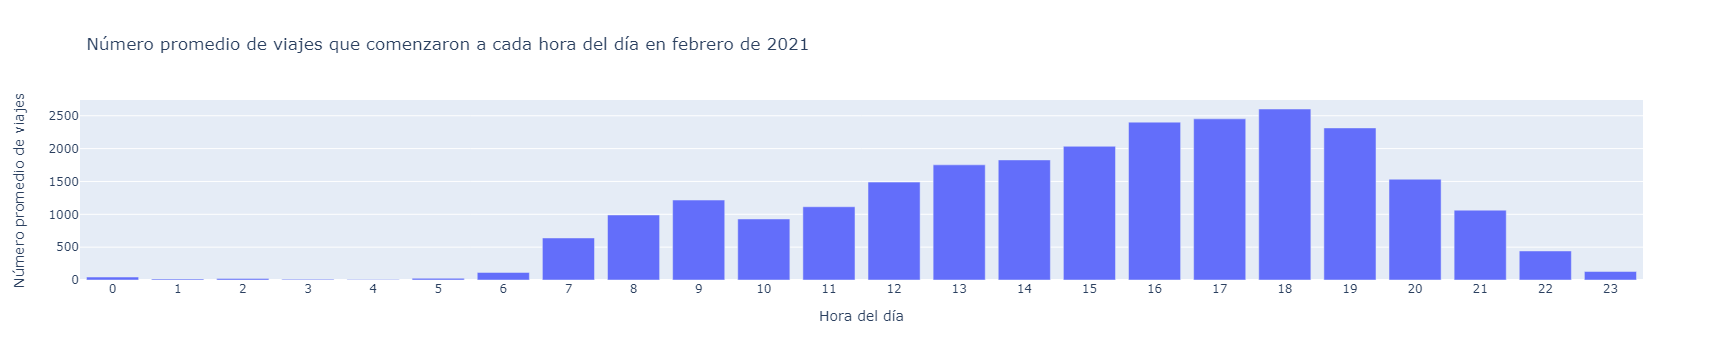

In [24]:
# Convertir la columna `tsO` a formato datetime si no lo has hecho
df['tsO'] = pd.to_datetime(df['tsO'], format='%d/%m/%Y %H:%M:%S')

# Extraer la hora de cada viaje
df['hour'] = df['tsO'].dt.hour

# Calcular el número promedio de viajes por cada hora
average_trips_per_hour = df.groupby('hour').size().groupby(level=0).mean()

# Crear un gráfico de barras interactivo con Plotly
fig = px.bar(
    average_trips_per_hour,
    x=average_trips_per_hour.index,
    y=average_trips_per_hour.values,
    labels={'x': 'Hora del día', 'y': 'Número promedio de viajes'},
    title='Número promedio de viajes que comenzaron a cada hora del día en febrero de 2021'
)

# Configurar ejes y diseño para mejor visualización
fig.update_layout(
    xaxis_title='Hora del día',
    yaxis_title='Número promedio de viajes',
    xaxis=dict(dtick=1),  # Mostrar todas las horas en el eje X
    template='plotly',     # Estilo para hacer el gráfico más agradable
    hovermode="x"          # Para un efecto de hover intuitivo
)

# Mostrar el gráfico interactivo
fig.show()

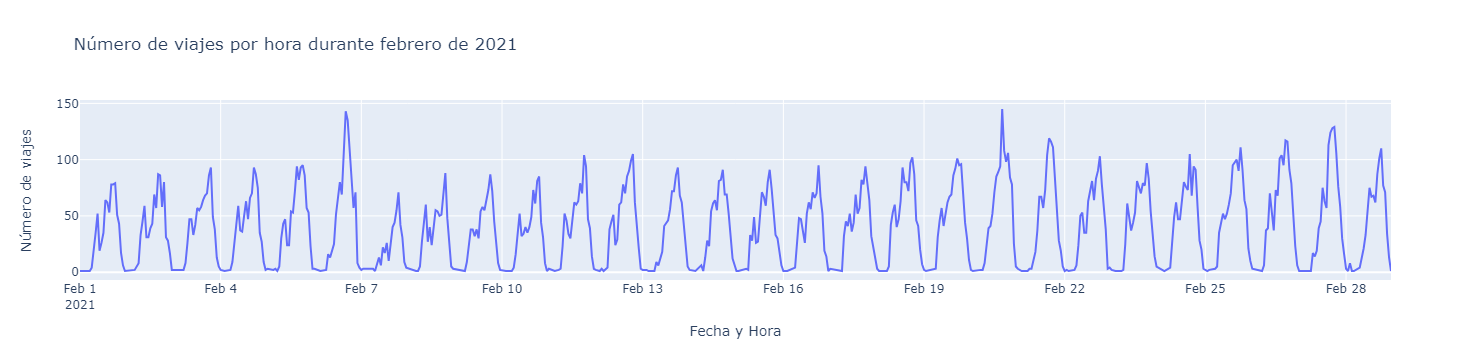

In [82]:
# Asegurarse de que la columna `tsO` esté en formato datetime
df['tsO'] = pd.to_datetime(df['tsO'], format='%d/%m/%Y %H:%M:%S')

# Agrupar los datos por fecha y hora y contar el número de viajes
viajes_por_hora = df.groupby(df['tsO'].dt.floor('H')).size().reset_index(name='Numero_viajes')

# Renombrar la columna agrupada como 'Fecha_Hora' para claridad
viajes_por_hora.rename(columns={'tsO': 'Fecha_Hora'}, inplace=True)

# Crear el gráfico interactivo
fig = px.line(
    viajes_por_hora,
    x='Fecha_Hora',
    y='Numero_viajes',
    title='Número de viajes por hora durante febrero de 2021',
    labels={'Fecha_Hora': 'Fecha y Hora', 'Numero_viajes': 'Número de viajes'},
)

# Mejorar la visualización con detalles en los ejes y el hover
fig.update_layout(
    xaxis_title='Fecha y Hora',
    yaxis_title='Número de viajes',
    template='plotly',
    hovermode='x'
)

# Mostrar el gráfico interactivo
fig.show()

### Precios de energía

In [59]:
# Cargar el archivo XLSX en un DataFrame llamado energia_df
energia_df = pd.read_excel('20210201_20210228_PUN.xlsx') 
energia_df, energia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    672 non-null    object
 1   Ora     672 non-null    int64 
 2   €/MWh   672 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.9+ KB


(           Data  Ora      €/MWh
 0    01/02/2021    1  41,177380
 1    01/02/2021    2  40,000000
 2    01/02/2021    3  40,000000
 3    01/02/2021    4  38,514970
 4    01/02/2021    5  34,867470
 ..          ...  ...        ...
 667  28/02/2021   20  61,725170
 668  28/02/2021   21  57,836670
 669  28/02/2021   22  52,263610
 670  28/02/2021   23  49,062890
 671  28/02/2021   24  43,610000
 
 [672 rows x 3 columns],
 None)

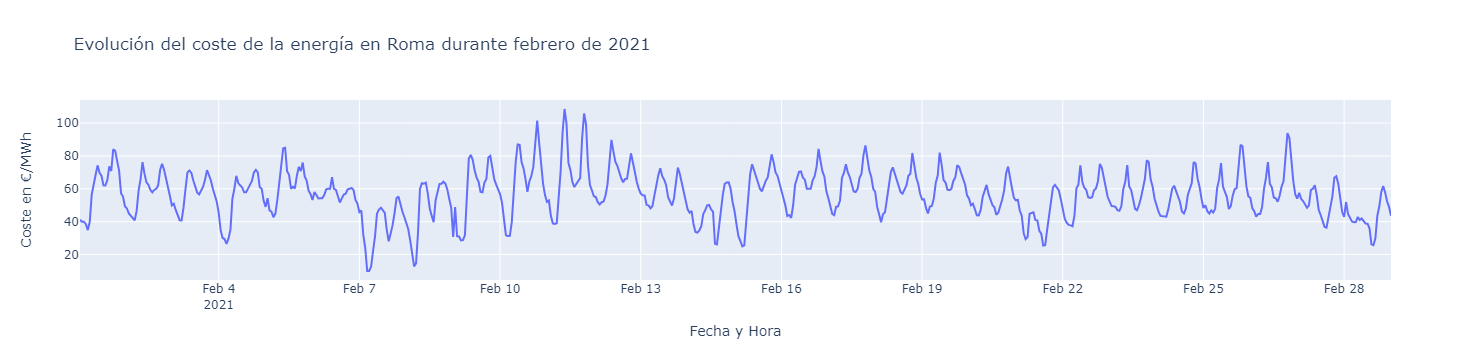

In [78]:
# Asegurarse de que todos los valores en la columna `€/MWh` sean cadenas antes de aplicar operaciones de cadena
energia_df['€/MWh'] = energia_df['€/MWh'].astype(str).str.replace(',', '.')

# Convertir la columna `€/MWh` a numérica
energia_df['€/MWh'] = pd.to_numeric(energia_df['€/MWh'], errors='coerce')

# Convertir la columna `Data` a formato datetime con el formato adecuado
energia_df['Data'] = pd.to_datetime(energia_df['Data'], format='%d/%m/%Y')

# Crear una columna de fecha y hora combinando `Data` y `Ora`
energia_df['Fecha_Hora'] = energia_df['Data'] + pd.to_timedelta(energia_df['Ora'], unit='h')

# Crear el gráfico interactivo
fig = px.line(
    energia_df,
    x='Fecha_Hora',
    y='€/MWh',
    title='Evolución del coste de la energía en Roma durante febrero de 2021',
    labels={'Fecha_Hora': 'Fecha y Hora', '€/MWh': 'Coste en €/MWh'}
)

# Mejorar la visualización con detalles en los ejes y el hover
fig.update_layout(
    xaxis_title='Fecha y Hora',
    yaxis_title='Coste en €/MWh',
    template='plotly',
    hovermode='x'
)

# Mostrar el gráfico interactivo
fig.show()
